**Deep neural networks and learning systems - Assessment**

#*Part I: Reading and exploring the data*

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim

##**Setting up the dataset**

The dataset is located in a different drive (public). Therefore, we need to add a shortcut to the data directory in our own drive.

**Original dataset**

Open the dataset external drive: [https://drive.google.com/drive/folders/1DUf3nGNNFk6YjRjQtZPfAY5N105GoGJb](https://drive.google.com/drive/folders/1DUf3nGNNFk6YjRjQtZPfAY5N105GoGJb) and click in add shortcut.

**Reduced images**

I have also created a separate folder with reduced size images to accelerate model training. *You also need a shortcut to this folder in your own drive*:

https://drive.google.com/drive/folders/18niX9leMkIxIhD1st-f6yR0s1HWTGBkV?usp=drive_link

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir = '/content/drive/MyDrive/'

algonauts_dir = 'algonauts_2023_tutorial_data' # Path to the shortcut in your drive
reduced_images_dir = 'reduced_images_algonauts' # Path to the shortcut in your drive

# Loading reduced images
reduced_images = np.load(os.path.join(root_dir, reduced_images_dir, 'subj01', 'images.npy'))

## **Utility functions**

The following functions can be used to load the FMRI data from a given subject, load activity from a given region of interest or loading the corresponding image.

In [4]:
# Utility functions
def load_fmri_of_subject(subj, hemisphere, directory=root_dir):
    subj = format(subj, '02')
    data_dir = os.path.join(directory, algonauts_dir, 'subj' + subj, 'training_split', 'training_fmri')
    if hemisphere == 'left':
        brain_activity = np.load(os.path.join(data_dir, 'lh_training_fmri.npy'))
    else:
        brain_activity = np.load(os.path.join(data_dir, 'rh_training_fmri.npy'))
    return brain_activity

def load_fmri_region_of_interest(subj, roi, hemisphere, directory=root_dir):
    subj = format(subj, '02')
    data_dir = os.path.join(directory, algonauts_dir, 'subj' + subj)
    roi_classes = {
        "prf-visualrois": ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"],
        "floc-bodies": ["EBA", "FBA-1", "FBA-2", "mTL-bodies"],
        "floc-faces": ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"],
        "floc-places": ["OPA", "PPA", "RSC"],
        "floc-words": ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"],
        "streams": ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]
    }

    for roi_class, rois in roi_classes.items():
        if roi in rois:
            roi_class_dir = os.path.join(data_dir, 'roi_masks', hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
            roi_map_dir = os.path.join(data_dir, 'roi_masks', 'mapping_'+roi_class+'.npy')
            roi_class_idx = np.load(roi_class_dir)
            roi_map = np.load(roi_map_dir, allow_pickle=True).item()
            roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
            challenge_roi = np.asarray(roi_class_idx == roi_mapping, dtype=int)

            fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri')
            if hemisphere == 'left':
                brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
            else:
                brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

            fmri_roi_data = brain_activity[:, np.where(challenge_roi)[0]]
            return fmri_roi_data

def load_image_subject(subj, img, directory=root_dir):
    subj = format(subj, '02')
    data_dir = os.path.join(directory, algonauts_dir, 'subj' + subj)
    train_img_dir = os.path.join(data_dir, 'training_split', 'training_images')
    train_img_list = sorted(os.listdir(train_img_dir))

    img_dir = os.path.join(train_img_dir, train_img_list[img])
    train_img = Image.open(img_dir).convert('RGB')
    return train_img

def load_reduced_image_subject(subj, img, directory=root_dir):
    image = reduced_images[img]
    return Image.fromarray(image)


## **Explore the brain responses**


---



The next cells show you how to read some of the data. Explore the data structures so that you feel comfortable with them. First, start by getting familiar with the brain activations. What is their range? How do they change for different images?

(9841, 20544)


<BarContainer object of 2 artists>

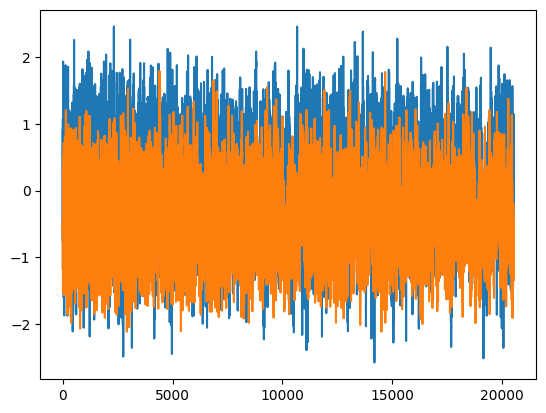

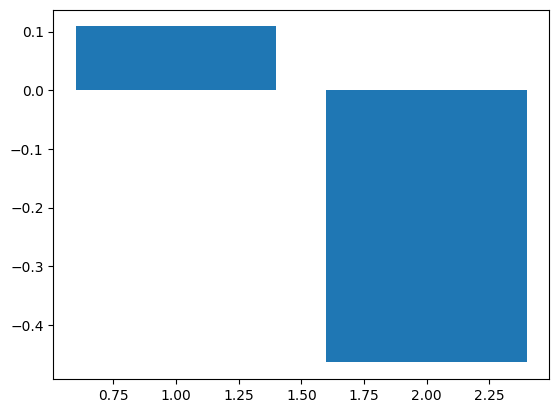

In [5]:
# Explore the brain responses
brain_activity = load_fmri_of_subject(subj=1, hemisphere='right')
print(brain_activity.shape)  # Images x brain activity
img1 = 340
img2 = 560
plt.plot(brain_activity[img1, :])
plt.plot(brain_activity[img2, :])
plt.figure()
activation1 = np.mean(brain_activity[img1, :])
activation2 = np.mean(brain_activity[img2, :])
plt.bar((1, 2), (activation1, activation2))

## **Selecting a particular ROIs**

You can be more accurate by selecting, from the total number of activations (voxels), those belonging to a particular regions. Those activations correspond to a particular location in the brain that has some functions significance:


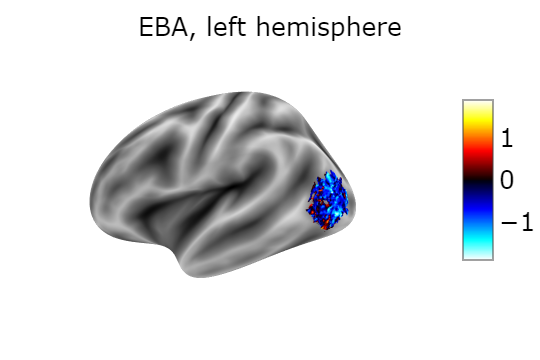:

In [6]:
# Selecting a particular ROIs
roi = "EBA"
fmri_roi_data = load_fmri_region_of_interest(subj=1, roi=roi, hemisphere='left')
print(fmri_roi_data.shape)

(9841, 2837)


## **Loading the images**

**Full size images**

Compare the activations and the images side-by-side, do you find any interesting patterns? what about different regions of interest, do they show differences?

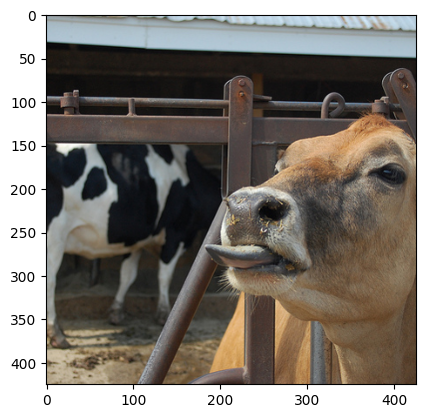

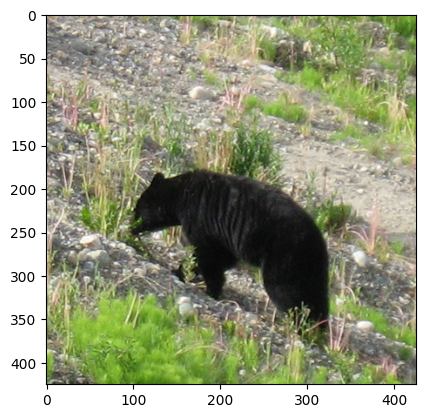

In [7]:
# Loading the images
train_img = load_image_subject(subj=1, img=430)
plt.imshow(train_img)
plt.figure()
train_img = load_image_subject(subj=1, img=img2)
plt.imshow(train_img)

**64x64 reduced images**


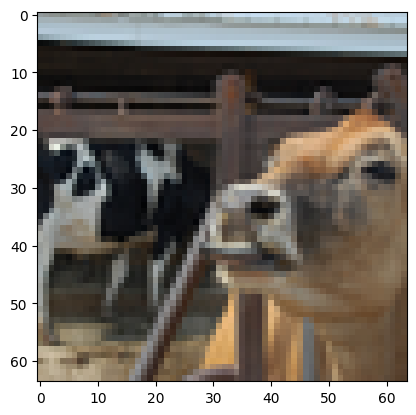

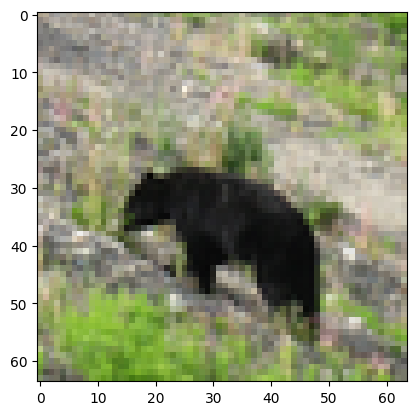

In [8]:
# 64x64 reduced images
train_img = load_reduced_image_subject(subj=1, img=430)
plt.imshow(train_img)
plt.figure()
train_img = load_reduced_image_subject(subj=1, img=img2)
plt.imshow(train_img)

# *PART II: Exctracting features from Autoencoder*



##**Building a decoder.**

First we create a dataset that represents ALL the brain activity. If you want to use a particular region you need to modify this class

In [9]:
# Building a decoder
class Encoder(nn.Module):
    def __init__(self, num_input_channels, base_channel_size, latent_dim, act_fn=nn.GELU):
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Flatten(),
            nn.Linear(2 * 16 * c_hid, latent_dim),
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, num_input_channels, base_channel_size, latent_dim, act_fn=nn.GELU):
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2 * 16 * c_hid), act_fn())
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, base_channel_size, latent_dim, encoder_class=Encoder, decoder_class=Decoder, num_input_channels=3):
        super().__init__()
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

Creating our train loader

In [10]:
# Data transformations
resize_normalize = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Brain dataset class
class BrainDataSet(Dataset):
    def __init__(self, subject, hemisphere, transform=None):
        self.subject = subject
        self.hemisphere = hemisphere
        self.fmri_data = load_fmri_of_subject(subject, hemisphere)
        self.data_len, self.num_samples = self.fmri_data.shape
        self.transform = transform

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        x = self.fmri_data[idx, :]
        img = load_reduced_image_subject(subj=self.subject, img=idx)
        return self.transform(img) if self.transform else img, torch.from_numpy(x),

# Data loader for subject 1
subject = 1
hemisphere = 'left'
myDataset = BrainDataSet(subject, hemisphere, resize_normalize)
train_loader = DataLoader(dataset=myDataset, batch_size=32, shuffle=True)

# Function to show images
def showImage(ax, image, title=''):
    image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(title)


##**Training the autoencoder**

We start by building an autoencoder network

epoch: 0, loss: 1.277327060699463
epoch: 0, loss: 0.5016048550605774
epoch: 0, loss: 0.4147316813468933
epoch: 0, loss: 0.37147092819213867
epoch: 1, loss: 0.45047205686569214
epoch: 1, loss: 0.390464723110199
epoch: 1, loss: 0.3081326186656952
epoch: 1, loss: 0.30786460638046265
epoch: 2, loss: 0.2866753041744232
epoch: 2, loss: 0.2716503143310547
epoch: 2, loss: 0.27523717284202576
epoch: 2, loss: 0.22404524683952332
epoch: 3, loss: 0.2023884505033493
epoch: 3, loss: 0.19704914093017578
epoch: 3, loss: 0.194469153881073
epoch: 3, loss: 0.18670254945755005
epoch: 4, loss: 0.22893354296684265
epoch: 4, loss: 0.20354700088500977
epoch: 4, loss: 0.19834546744823456
epoch: 4, loss: 0.1886759251356125
epoch: 5, loss: 0.1836818903684616
epoch: 5, loss: 0.18480925261974335
epoch: 5, loss: 0.19571471214294434
epoch: 5, loss: 0.1684672236442566
epoch: 6, loss: 0.17664945125579834
epoch: 6, loss: 0.19777879118919373
epoch: 6, loss: 0.2052067518234253
epoch: 6, loss: 0.18288776278495789
epoch: 7

Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=1024, out_features=64, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=64, out_features=1024, bias=True)
      (1): GELU(approximate='none')
    )
    (net): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1,

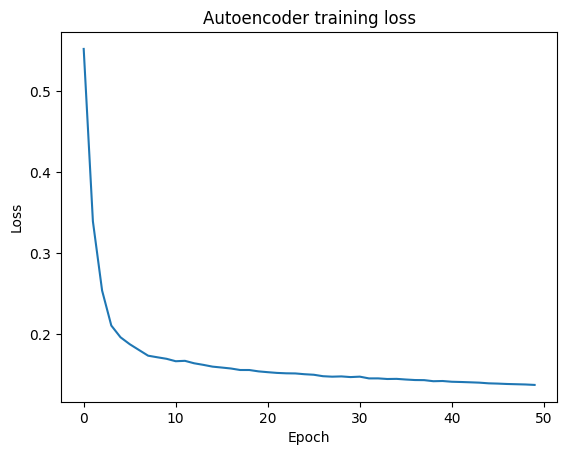

In [11]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load or train the autoencoder
TRAIN = True

def train_autoencoder(train_loader):
    PATH = 'autoencoder.pt'
    learning_rate = 1e-3
    criterion = nn.MSELoss()

    amodel = Autoencoder(base_channel_size=32, latent_dim=64)
    amodel = amodel.to(device)
    optimizer = torch.optim.Adam(amodel.parameters(), lr=learning_rate)
    epochs = 50

    Losses_mean = np.zeros(epochs)
    Losses_std = np.zeros(epochs)

    for i in range(epochs):
        current_losses = []

        for k, (x, y) in enumerate(train_loader):
            x = x.to(device)
            x_rec = amodel(x)

            loss = criterion(x, x_rec)
            current_losses += [loss.item()]

            if k % 100 == 0:
                print(f'epoch: {i}, loss: {loss.item()}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Losses_mean[i] = np.mean(np.array(current_losses))
        Losses_std[i] = np.std(np.array(current_losses))
        torch.save({
            'epoch': i,
            'model_state_dict': amodel.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': Losses_mean[i],
        }, PATH)

    model_save_name = 'final_autoencoder.pt'
    path = F"/content/drive/MyDrive/{model_save_name}"
    torch.save(amodel.state_dict(), path)

    return amodel, Losses_mean, Losses_std

if TRAIN:
    amodel, loss_mean, loss_std = train_autoencoder(train_loader)
    plt.plot(loss_mean)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Autoencoder training loss')
else:
    amodel = Autoencoder(base_channel_size=32, latent_dim=64)
    amodel.load_state_dict(torch.load('/content/drive/MyDrive/final_autoencoder.pt'))

amodel.to(device)
amodel.eval()

testing the train encoder:

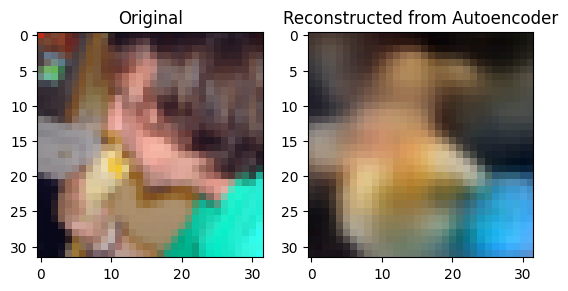

In [12]:
# Testing the trained autoencoder
image, activity = next(iter(train_loader))
image = image.to(device)
reconstructed_image = amodel(image)
fig, ax = plt.subplots(1, 2)
showImage(ax[0], image.cpu()[0, :, :, :], title='Original')
showImage(ax[1], reconstructed_image.cpu().detach()[0, :, :, :], title='Reconstructed from Autoencoder')


## **Creating a decoder from the brain activity**

Now we create a personalized neural network that replaces the encoder in our autoencoder. We called brain decoder because it translates brain signals into latent vectors.

epoch: 0, loss: 0.2245764434337616
epoch: 1, loss: 0.20394249260425568
epoch: 2, loss: 0.17156057059764862
epoch: 3, loss: 0.1767921894788742
epoch: 4, loss: 0.18631909787654877
epoch: 5, loss: 0.18101325631141663
epoch: 6, loss: 0.1441313624382019
epoch: 7, loss: 0.17882812023162842
epoch: 8, loss: 0.18316137790679932
epoch: 9, loss: 0.13305002450942993
epoch: 10, loss: 0.1497911512851715
epoch: 11, loss: 0.1419132947921753
epoch: 12, loss: 0.15372803807258606
epoch: 13, loss: 0.14120766520500183
epoch: 14, loss: 0.15649329125881195
epoch: 15, loss: 0.16695623099803925
epoch: 16, loss: 0.15074613690376282
epoch: 17, loss: 0.149110808968544
epoch: 18, loss: 0.14900001883506775
epoch: 19, loss: 0.12766148149967194


Text(0, 0.5, 'Loss')

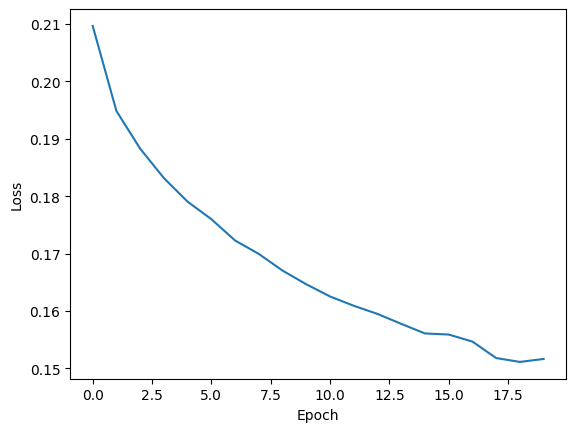

In [13]:
# Enhanced BrainDecoder with more layers
class BrainDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BrainDecoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc4 = nn.Linear(hidden_size // 4, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

# The input size is the size of the vector of the brain activity
image, activity = next(iter(train_loader))
size_brain_activity = activity.shape[1]
latent_dimension = 64
myBrainDecoder = BrainDecoder(input_size=size_brain_activity, hidden_size=3000, output_size=latent_dimension)
myBrainDecoder.to(device)

# Train your decoder with a different loss function (Huber loss)
learning_rate = 1e-3
optimizer = torch.optim.Adam(myBrainDecoder.parameters(), lr=learning_rate)
criterion = nn.HuberLoss()  # Using Huber loss
epochs = 20

Losses_mean = np.zeros(epochs)
Losses_std = np.zeros(epochs)

for i in range(epochs):
    current_losses = []

    for k, (x, brain_activity) in enumerate(train_loader):
        x = x.to(device)
        brain_activity = brain_activity.to(device)
        latent_code = amodel.encoder(x)
        y = myBrainDecoder(brain_activity)
        loss = criterion(y, latent_code)
        current_losses += [loss.item()]

        if k % 500 == 0:
            print(f'epoch: {i}, loss: {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    Losses_mean[i] = np.mean(np.array(current_losses))
    Losses_std[i] = np.std(np.array(current_losses))
    torch.save({
        'epoch': i,
        'model_state_dict': myBrainDecoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': Losses_mean[i],
    }, '/content/drive/MyDrive/brain_decoder.pt')

plt.plot(Losses_mean)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Train your decoder

##**Reconstructing images from brain activity.**

Now that we have trained our brain decoder, we can try to reconstruct the image from brain activity.

<ipython-input-14-abd6319f5597>:15: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy(), reconstructed_image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy(), multichannel=True)


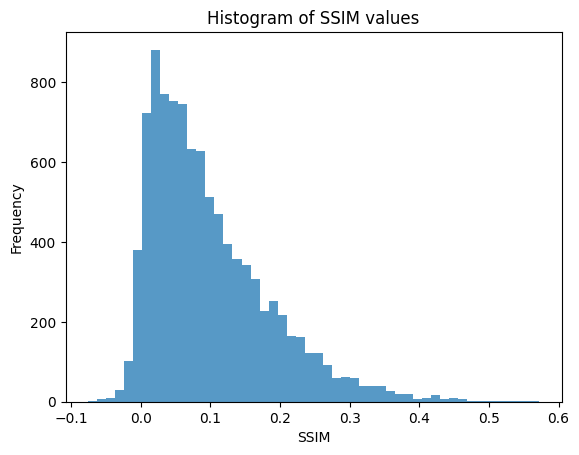

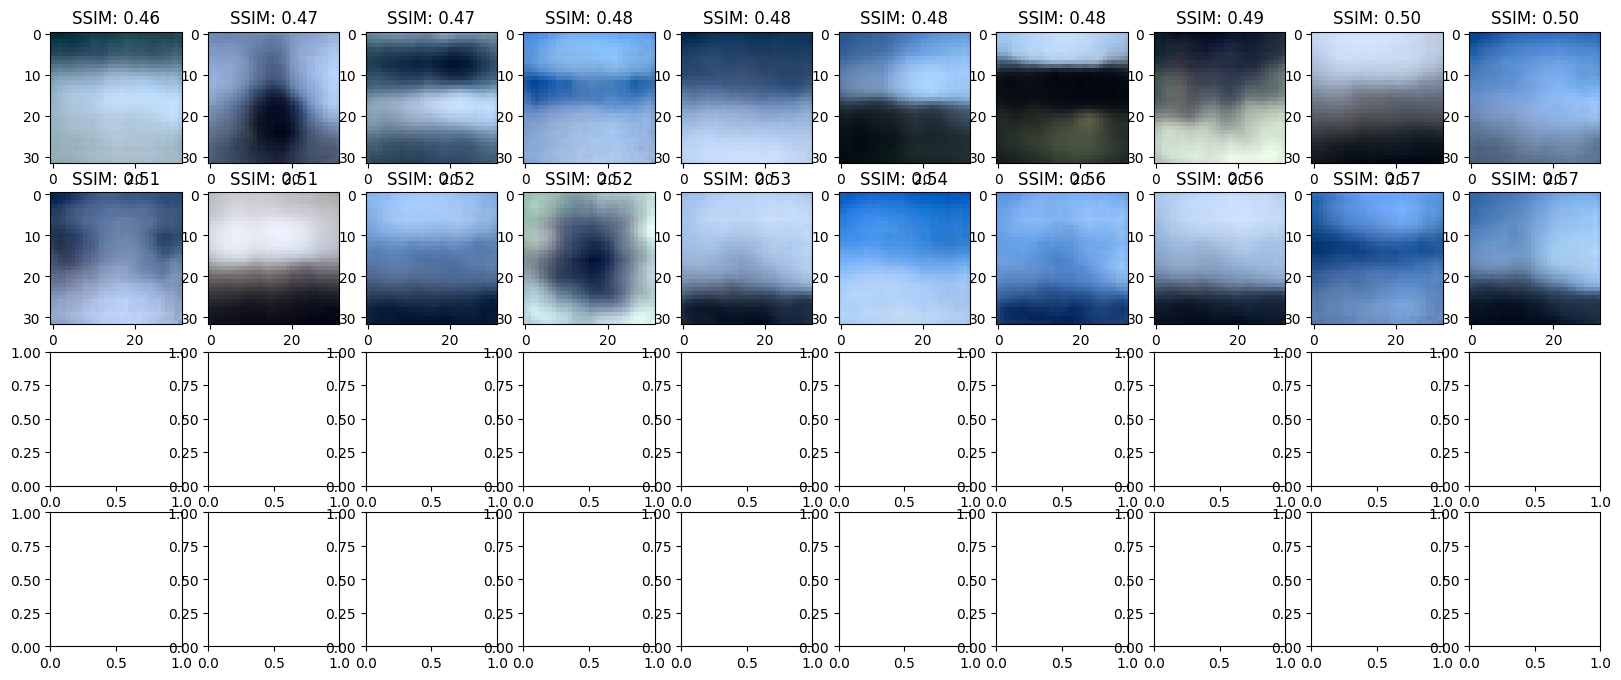

In [14]:
# Reconstructing all images from brain activity
all_reconstructed_images = []
all_original_images = []
ssim_values = []

for i in range(len(myDataset)):
    image, brain_activity = myDataset[i]
    image = image.to(device).unsqueeze(0)
    brain_activity = brain_activity.to(device).unsqueeze(0)
    z_brain = myBrainDecoder(brain_activity)
    reconstructed_image = amodel.decoder(z_brain)
    all_reconstructed_images.append(reconstructed_image.detach().cpu().squeeze(0))
    all_original_images.append(image.cpu().squeeze(0))

    ssim_value = ssim(image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy(), reconstructed_image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy(), multichannel=True)
    ssim_values.append(ssim_value)

# Plot histogram of SSIM values
plt.hist(ssim_values, bins=50, alpha=0.75)
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.title('Histogram of SSIM values')
plt.show()

# Select top 20 SSIM values and display corresponding images
top_20_indices = np.argsort(ssim_values)[-20:]
fig, axs = plt.subplots(4, 10, figsize=(20, 8))
for i, idx in enumerate(top_20_indices):
    ax = axs[i // 10, i % 10]
    showImage(ax, all_reconstructed_images[idx], title=f'SSIM: {ssim_values[idx]:.2f}')

plt.show()


#**Example questions you can ask:**

1. (Changes of the model at least 1) Does adding more layer to BrainDecoder improve the result? The quality? Or adding Convolutional layers? Or trying different loss function? Doing PCA before?
2. Is the reconstruction better if we use brain activtity from region V1d (which is purely visual) or EBA which is related to places (X vs Y, two different regions)
3. Compare different subject? Subj 1 vs Subj 2
4. Choose categories of images (Cities vs Nature)
5. Can try to generate a text description of the image (advanced)
6. Classification: generate some labels from the images (using ResNet), you use you latent code to train a classifier
7. Sentiment